In [1]:
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import numpy as np
# Saving and type checking
import shutil

# Operators
import ufl
from ufl import TrialFunction, TestFunction, FacetNormal, SpatialCoordinate
from ufl import dx, ds, exp, sym, tr, sqrt
from ufl import nabla_div, nabla_grad,grad,div
from ufl import as_matrix as matrix
from ufl import lhs, rhs
# Graphics
import matplotlib.pyplot as plt

# Logging

import time


def progress(sequence, every=1):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(
        description='Solving', min=0, max=len(sequence), value=0
        )
    display(progress)

    for index, record in enumerate(sequence):

        if index % every == 0:
            progress.value = index
        yield record
    progress.value = len(sequence)


# Operators
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.dot)
inner = Infix(ufl.inner)


def vector(*args):
    return ufl.as_vector(tuple(args))


npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return ufl.Identity(func_like.geometric_dimension())


# Classes:


def Function(space, func=None):
    """Function on new space. Without func just create a Function on space. 
    Args:
        space (FunctionSpace): New space
        function (): 
    \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
    \nVectors - fem.vector_Function,fem.vector_Constant, ufl_vector_function, callable vector_function, tuple_number
    Returns:
        fem.Function: Function
    """

    result = fem.Function(space)
    tupe = str(func.__class__)[8:-2]
    cord = SpatialCoordinate(space)

    # None
    if func == None:
        return result

    # fem.Function
    elif tupe == ('dolfinx.fem.function.Function'):
        expression = func

    # fem.Constant
    elif tupe == ('dolfinx.fem.function.Constant'):
        if len(func.ufl_shape) == 0: func2 = func.value + (cord[0] - cord[0])
        else:
            func2 = vector(*func.value) +\
                vector(*map(lambda x, y: x - y, cord, cord))
        expression = fem.Expression(func2, space.element.interpolation_points())

    # ufl object
    elif tupe[:3] == 'ufl':
        if len(func.ufl_shape) != 0:
            func2 = func + vector(*map(lambda x, y: x - y, cord, cord))
        else:
            func2 = func
        expression = fem.Expression(func2, space.element.interpolation_points())

    # Python function
    elif tupe == ('function'):
        expression = func

        # Number
    elif not hasattr(func, '__call__'):
        if hasattr(func, '__getitem__'):
            func2 = vector(*func) + vector(*map(lambda x, y: x - y, cord, cord))
        else:
            func2 = func + (cord[0] - cord[0])
        expression = fem.Expression(func2, space.element.interpolation_points())

    result.interpolate(expression)
    return result


def Constant(domain_space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace| domain): Space or domain
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return fem.Constant(domain_space, fem.petsc.PETSc.ScalarType(const))


def create_facet_markers(domain, bound_markers):
    """Mark facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function
    
    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    """Create Dirichlet condition

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function or Constant
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(mesh.meshtags, marker) - list or tuple, marker of boundary from Marked_facets - mesh.meshtags
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == (tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=combined_marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Post processing:


def errors_L(space, uS, uEx):
    # Fix it for vectors
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = space.mesh

    L1_scalar = fem.assemble_scalar(fem.form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(fem.form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph from fem.Function

    Args:
        fig (plt.Figure): Figure
        lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
        method (bool): Graph method True = tripcolor, False = tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return


# Solvers
class Problem:
    import typing

    def __init__(
        self,
        a: ufl.Form,
        L: ufl.Form,
        bcs: typing.List[fem.petsc.DirichletBCMetaClass] = [],
        u: fem.Function = None,
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
            },
        assemble_options={},
        ghost_opions={},
        form_compiler_params={},
        jit_params={},
        ):
        """Create linear (nonlinear) problem

        Args:
            a (ufl.Form): bilinear form
            L (ufl.Form): linear form
            bcs (typing.List[fem.petsc.DirichletBCMetaClass], optional): Dirichlet conditious. Defaults to [].
            u (fem.Function, optional): Function to be solved. Defaults to None.
            petsc_options (dict, optional): Options to petsc. Defaults to { 'ksp_type': 'preonly', 'pc_type': 'lu' }.
            assemble_options (dict, optional): Options to assemble bilinear and linear forms. 
            Defaults to {'assebmle_A': True, 'assemble_B': True}.
            ghost_opions (dict, optional): GhostUpdate potions. Defaults to  {'addv': ADD,'mode': REVERSE}.
            form_compiler_params (dict, optional): Form compiler options. Defaults to {}.
            jit_params (dict, optional): JIT parmetrs. Defaults to {}.
        """

        def set_options(self):
            problem_prefix = f'dolfinx_solve_{id(self)}'
            self._solver.setOptionsPrefix(problem_prefix)
            opts = fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            self._solver.setFromOptions()
            self._A.setOptionsPrefix(problem_prefix)
            self._A.setFromOptions()
            self._b.setOptionsPrefix(problem_prefix)
            self._b.setFromOptions()

        # Creating u function
        if u is None:
            # Extract function space from TrialFunction (which is at the
            # end of the argument list as it is numbered as 1, while the
            # Test function is numbered as 0)
            self._u = fem.Function(a.arguments()[-1].ufl_function_space())
        else:
            self._u = u

        # Forms and bcs
        self._bcs = bcs

        self._a = fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._A = fem.petsc.create_matrix(self._a)

        self._L = fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._b = fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
            )
        self._solver.setOperators(self._A)
        set_options(self)

        # Another options
        self._ghost_opions = {
            'addv': fem.petsc.PETSc.InsertMode.ADD,
            'mode': fem.petsc.PETSc.ScatterMode.REVERSE,
            }
        self._ghost_opions.update(ghost_opions)
        self._assemble_options = {'assebmle_A': True, 'assemble_B': True}
        self._assemble_options.update(assemble_options)

    def assemble_A(self):
        """Assemle bilinear form"""
        self._A.zeroEntries()
        fem.petsc._assemble_matrix_mat(self._A, self._a, bcs=self._bcs)
        self._A.assemble()

    def assemble_b(self):
        """Assemble linear form"""
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        fem.petsc.assemble_vector(self._b, self._L)

        fem.petsc.apply_lifting(self._b, [self._a], bcs=[self._bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
            )
        fem.petsc.set_bc(self._b, self._bcs)

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        if self._assemble_options['assebmle_A'] == True: self.assemble_A()
        if self._assemble_options['assebmle_A'] == True: self.assemble_b()
        self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return self._u

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return fem.petsc.PETSc.PC.Type

    @staticmethod
    def ghost_updates():
        """Get ghost_update types"""
        return (fem.petsc.PETSc.InsertMode, fem.petsc.PETSc.ScatterMode)

    # @classmethod
    # def HYPER_types():
    # return fem.petsc.PETSc

    @property
    def L(self) -> fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver

In [2]:
import gmsh
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
from dolfinx.graph import create_adjacencylist
import dolfinx.io.gmshio

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(
            boundary[0], boundary[1]
            )
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass,
                         [L / 2, H, 0
                          ]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

res_min = r / 3.7
res_max = 1.5 * r
if mesh_comm.rank == model_rank:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8 * r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")
domain, _, ft = io.gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Ellipse)
Info    : Done meshing 1D (Wall 0.0081146s, CPU 0.009026s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Simple recombination completed (Wall 0.0235095s, CPU 0.023509s): 1180 quads, 354 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.773076, min Q = 0.435836
Info    : Done meshing 2D (Wall 0.0641771s, CPU 0.064298s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 50%] Meshing curve 4 order 2
Info    : [ 70%] Meshing curve 5 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 0.845684 (0 elements in ]0, 0.2]); wo

In [3]:
ft
fluid_marker,inlet_marker, outlet_marker, wall_marker, obstacle_marker

(1, 2, 3, 4, 5)

In [4]:
V = VectorFunctionSpace(domain, ('CG', 2))
Q = FunctionSpace(domain, ('CG', 2))
x, y = SpatialCoordinate(V)
dx = ufl.Measure('cell', subdomain_id='everywhere')

create_connectivity(domain=domain)
ds = ufl.Measure("ds", domain=domain)
n = FacetNormal(domain)
u, v = TrialFunction(V), TestFunction(V)
u_, u_n, u_n1, u_s = Function(V), Function(V), Function(V), Function(V)
u_.name = 'Velocity'

p, q, = TrialFunction(Q), TestFunction(Q)
p_ = Function(Q)
p_.name = 'Pressure'
phi = Function(Q)

In [5]:
T = 1
Nt = 5
dt =  T / Nt

time = Constant(domain, 0)
mu = Constant(domain, 0.001)
rho = Constant(domain, 1)
f = Constant(V, (0, 0))

u_inlet = vector(6 * ufl.sin(1 * ufl.pi / 8) * y * (0.41-y) / (0.41**2), 0)
u_noslip = vector(0, 0)

sigma = lambda u, p: 2 * mu * sym(grad(u)) - p * I(u)

bcsV = [
    DirichletBC(V, Function(V, u_noslip), (ft, wall_marker)),
    DirichletBC(V, Function(V, u_noslip), (ft, obstacle_marker)),
    DirichletBC(V, Function(V, u_inlet), (ft, inlet_marker)),
    ]

bcsQ = [
    DirichletBC(Q, Constant(Q, 0), (ft, outlet_marker)),
    ]
# from ufl import nabla_grad
# from ufl import dot
# from ufl import inner

F1 = rho / dt * ((u - u_n)|dot|v) * dx
F1 += (((1.5 * (u_n|dot|grad(u_n))) -\
    0.5 * (u_n1|dot|grad(u_n1)))|inner|v) * dx
F1 += 0.5 * mu * (grad(u + u_n)|inner|grad(v)) * dx
F1 += -(p_|dot|div(v)) * dx
F1 += (f|dot|v) * dx

F2 = (grad(p)|dot|grad(q)) * dx
F2 += 1 / dt * (div(u_s)|dot|q) * dx

F3 = (u|dot|v) * dx - (u_s|dot|v) * dx
F3 += dt * (grad(phi)|dot|v) * dx

# F1 = rho / dt * dot(u - u_n, v) * dx
# F1 += inner(
#     1.5 * dot(u_n, nabla_grad(u_n)) - 0.5 * dot(u_n1, nabla_grad(u_n1)), v
#     ) * dx
# F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
# F1 += dot(f, v) * dx

# F2 = dot(grad(p), grad(q)) * dx
# F2 += 1 / dt * dot(div(u_s), q) * dx

# F3 = dot(u, v) * dx
# F3 += dot(u_s, v) * dx - dt * dot(nabla_grad(phi), v) * dx


In [6]:
addv, mod = Problem.ghost_updates()
addv = addv.ADD_VALUES
mod = mod.REVERSE

problem1 = Problem(
    lhs(F1),
    rhs(F1),
    bcsV,
    u=u_s,
    petsc_options={
        'ksp_type': 'bcgs',
        'pc_type': 'jacobi',
        },
    assemble_options={'assemble_b': False},
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )

problem2 = Problem(
    lhs(F2),
    rhs(F2),
    bcsQ,
    u=phi,
    petsc_options={
        'ksp_type': 'minres',
        'pc_type': 'hypre',
        'hypretype': 'boomeramg',
        },
    assemble_options={'assemble_b': False},
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )

problem3 = Problem(
    lhs(F3),
    rhs(F3),
    u=u_,
    petsc_options={
        'ksp_type': 'cg',
        'pc_type': 'sor',
        },
    assemble_options={'assemble_b': False},
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )

In [7]:
try:
    shutil.rmtree('/home/VTK/2.2Stokes_Files')
except:
    print('Directory empty yet')

with io.VTKFile(
    domain.comm, '/home/VTK/2.2Stokes_Files/stokes.pvd', 'w'
    ) as file:
    for t in progress(np.arange(0, T+2*dt, dt)):
        u_n1.interpolate(u_n)
        u_n.interpolate(u_)
        file.write_function([u_, p_], t)
        time.value = t

        problem1.assemble_b()
        u_s = problem1.solve()

        problem2.assemble_b()
        phi = problem2.solve()
        p_.interpolate(Function(Q,phi+p_))

        problem3.assemble_b()
        u_ = problem3.solve()

IntProgress(value=0, description='Solving', max=7)

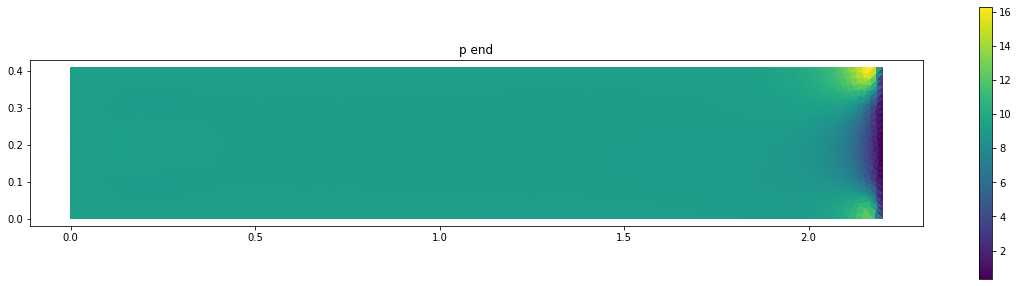

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
graph2D(
    fig=fig,
    lists=[[p_, ax, 'p end']],
    natural_show=True,     # points_on=True,
    )